# End-to-End Data Science Pipeline: Analyzing Delhi's Air Quality Index (AQI)

## Project Overview
Delhi is known for having one of the most complex air pollution profiles in the world, often driven by seasonal factors, traffic, and industrial activities. This project focuses on analyzing historical Air Quality Index (AQI) data retrieved from a database. The goal is to process raw data into actionable insights and potentially build a predictive model for future air quality trends.

Below is the comprehensive Data Science workflow applied in this project, covering everything from data extraction to model evaluation.

---

## 1. Business Understanding & Domain Knowledge
Before diving into the code, it is crucial to understand the context of Delhi's pollution:
*   **Objective:** To analyze historical trends, identify critical pollution periods, and forecast AQI levels.
*   **Key Factors:** Delhi's AQI is heavily influenced by seasonal changes (especially winter), stubble burning in neighboring states, and festivals like Diwali.
*   **Metrics:** We focus on pollutants such as PM2.5, PM10, NO2, CO, SO2, and O3.

## 2. Data Collection & Extraction
The data resides in a relational database.
*   **Action:** Establish a connection using SQL connectors (e.g., `SQLAlchemy` or `psycopg2`).
*   **Querying:** Fetch relevant features and ensure the data granularity (hourly/daily) matches the analytical goals.

## 3. Data Cleaning & Preprocessing
Real-world sensor data is rarely clean. This phase handles the "noise":
*   **Missing Values:** Sensors often fail or undergo maintenance. We handle nulls using interpolation (linear/time-based) rather than simple dropping to maintain time-series continuity.
*   **Outlier Detection:** Distinguishing between sensor errors (e.g., negative values) and extreme pollution events (e.g., AQI > 500 during smog episodes).
*   **Type Conversion:** Converting timestamp strings into proper Python `datetime` objects for time-based indexing.

## 4. Exploratory Data Analysis (EDA)
Uncovering patterns and trends through visualization:
*   **Time Series Analysis:** Visualizing long-term trends to identify the annual "smog season" (typically October to January).
*   **Correlation Analysis:** Using Heatmaps to see how different pollutants correlate (e.g., PM2.5 vs. PM10).
*   **Distribution Check:** Understanding the spread of AQI values (Skewness/Kurtosis).

## 5. Feature Engineering
Transforming raw data into meaningful features for modeling:
*   **Temporal Features:** Extracting Hour, Day, Month, and Weekend indicators to capture rush-hour and seasonal effects.
*   **Lag Features:** Creating "Lag 1" or "Lag 24" features (past values) since current air quality is highly dependent on the state of the air in previous hours.
*   **Rolling Statistics:** Calculating rolling means (moving averages) to smooth out short-term fluctuations.

## 6. Modeling (Forecasting)
*   **Model Selection:** Applying time-series compatible models such as ARIMA, SARIMA, or Machine Learning regressors like XGBoost/Random Forest.
*   **Training:** Splitting data into Training and Testing sets chronologically (to avoid data leakage in time series).

## 7. Evaluation
Measuring the success of the analysis/model:
*   **Metrics:** Using RMSE (Root Mean Squared Error) or MAE (Mean Absolute Error) to quantify the deviation between predicted and actual AQI values.

---

**The following code demonstrates the technical implementation of this pipeline:**

In [4]:
pip install pandas

In [12]:
import os
df = pd.read_excel('/content/Dehli_AQI_Data.xlsx')
df.columns

Index(['datetime', 'date', 'year', 'month', 'day', 'hour', 'day_of_week',
       'is_weekend', 'season', 'city', 'station', 'latitude', 'longitude',
       'pm25', 'pm10', 'no2', 'so2', 'co', 'o3', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'aqi', 'aqi_category'],
      dtype='object')

In [16]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import skew, kurtosis

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
df.shape

(201664, 25)

### Step 1: Data Loading & Initial Inspection

In [17]:
# Display basic information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nDate Range: {df['datetime'].min()} to {df['datetime'].max()}")

# Display first few rows
print("\n" + "="*80)
print("FIRST 5 ROWS")
print("="*80)
display(df.head())

# Data types and missing values
print("\n" + "="*80)
print("DATA TYPES & MISSING VALUES")
print("="*80)
info_df = pd.DataFrame({
    'Column': df.columns,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null %': (df.isnull().sum() / len(df) * 100).round(2),
    'Dtype': df.dtypes
})
display(info_df)

# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
display(df.describe())

DATASET OVERVIEW

Dataset Shape: 201664 rows × 25 columns

Date Range: 2020-01-01 06:00:00 to 2025-12-31 23:00:00

FIRST 5 ROWS


,datetime,date,year,month,day,hour,day_of_week,is_weekend,season,city,station,latitude,longitude,pm25,pm10,no2,so2,co,o3,temperature,humidity,wind_speed,visibility,aqi,aqi_category
0,2020-01-01 06:00:00,2020-01-01,2020,1,1,6,Wednesday,0,winter,Delhi,"Anand Vihar, Delhi",28.6469,77.3164,371.8,739.4,119.6,47.7,5.19,12.3,9.4,100,3.6,1.2,500,Severe
1,2020-01-01 12:00:00,2020-01-01,2020,1,1,12,Wednesday,0,winter,Delhi,"Anand Vihar, Delhi",28.6469,77.3164,301.1,588.8,117.9,39.3,4.32,15.8,20.6,50,5.9,1.4,500,Severe
2,2020-01-01 18:00:00,2020-01-01,2020,1,1,18,Wednesday,0,winter,Delhi,"Anand Vihar, Delhi",28.6469,77.3164,334.0,602.6,150.1,36.3,7.13,14.3,12.4,56,4.5,1.1,500,Severe
3,2020-01-01 23:00:00,2020-01-01,2020,1,1,23,Wednesday,0,winter,Delhi,"Anand Vihar, Delhi",28.6469,77.3164,403.8,841.8,142.0,30.3,4.90,13.2,14.4,48,5.8,1.4,500,Severe
4,2020-01-01 06:00:00,2020-01-01,2020,1,1,6,Wednesday,0,winter,Delhi,"Jahangirpuri, Delhi",28.7299,77.1718,433.2,784.7,138.4,41.5,7.56,15.4,6.8,100,2.8,0.4,500,Severe



DATA TYPES & MISSING VALUES


,Column,Non-Null Count,Null Count,Null %,Dtype
datetime,datetime,201664,0,0.0,datetime64[ns]
date,date,201664,0,0.0,datetime64[ns]
year,year,201664,0,0.0,int64
month,month,201664,0,0.0,int64
day,day,201664,0,0.0,int64
hour,hour,201664,0,0.0,int64
day_of_week,day_of_week,201664,0,0.0,object
is_weekend,is_weekend,201664,0,0.0,int64
season,season,201664,0,0.0,object
city,city,201664,0,0.0,object



STATISTICAL SUMMARY


,datetime,date,year,month,day,hour,is_weekend,latitude,longitude,pm25,pm10,no2,so2,co,o3,temperature,humidity,wind_speed,visibility,aqi
count,201664,201664,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000,201664.000000
mean,2023-01-01 02:44:59.999999744,2022-12-31 12:00:00.000000512,2022.499544,6.521898,15.732664,14.750000,0.285584,28.596791,77.208600,183.420341,348.567402,69.761495,16.028998,3.033964,27.185762,26.895227,61.041564,10.528524,5.007801,265.830148
min,2020-01-01 06:00:00,2020-01-01 00:00:00,2020.000000,1.000000,1.000000,6.000000,0.000000,28.372200,77.026600,15.000000,24.000000,8.000000,4.000000,0.300000,12.000000,6.000000,20.000000,2.100000,0.200000,25.000000
25%,2021-07-02 04:15:00,2021-07-01 18:00:00,2021.000000,4.000000,8.000000,10.500000,0.000000,28.530800,77.071200,55.300000,104.100000,19.900000,4.500000,0.870000,18.000000,19.900000,39.000000,5.900000,1.900000,103.000000
50%,2023-01-01 02:30:00,2022-12-31 12:00:00,2022.500000,7.000000,16.000000,15.000000,0.000000,28.624600,77.201000,99.500000,189.800000,38.300000,8.700000,1.690000,23.300000,27.600000,58.000000,9.200000,4.400000,232.000000
75%,2024-07-02 00:45:00,2024-07-01 06:00:00,2024.000000,10.000000,23.000000,19.250000,1.000000,28.668300,77.316400,254.700000,481.200000,94.000000,20.900000,4.120000,31.800000,33.500000,83.000000,14.200000,7.100000,464.000000
max,2025-12-31 23:00:00,2025-12-31 00:00:00,2025.000000,12.000000,31.000000,23.000000,1.000000,28.776200,77.504000,900.000000,1979.700000,593.500000,121.600000,22.670000,84.000000,44.800000,100.000000,31.500000,15.000000,500.000000
std,NaN,NaN,1.708185,3.448995,8.801392,6.378691,0.451693,0.112215,0.125113,193.138161,370.016790,75.972086,17.201027,3.284094,13.569802,8.984843,24.737106,6.045043,3.685609,171.508950


### Step 2: Data Cleaning & Preprocessing

In [18]:
# Make a copy of the original data
df_clean = df.copy()

# Convert datetime column to proper datetime type (if not already)
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])
df_clean['date'] = pd.to_datetime(df_clean['date'])

# Set datetime as index for time series analysis
df_clean.set_index('datetime', inplace=True)
df_clean.sort_index(inplace=True)

print("✓ Datetime conversion completed")

# Check for missing values in key pollutant columns
pollutants = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
weather_vars = ['temperature', 'humidity', 'wind_speed', 'visibility']

print("\n" + "="*80)
print("MISSING VALUES IN KEY COLUMNS")
print("="*80)

# Check if these columns exist in your dataframe
available_pollutants = [col for col in pollutants if col in df_clean.columns]
available_weather = [col for col in weather_vars if col in df_clean.columns]

missing_summary = pd.DataFrame({
    'Column': available_pollutants + available_weather + ['aqi'],
    'Missing Count': [df_clean[col].isnull().sum() for col in available_pollutants + available_weather + ['aqi']],
    'Missing %': [(df_clean[col].isnull().sum() / len(df_clean) * 100)
                  for col in available_pollutants + available_weather + ['aqi']]
})
display(missing_summary)

# Handle missing values - using forward fill then backward fill for time series
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_columns] = df_clean[numeric_columns].fillna(method='ffill').fillna(method='bfill')

print("\n✓ Missing values handled using forward/backward fill")

# Detect and handle outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("\n" + "="*80)
print("OUTLIER DETECTION (3×IQR Method)")
print("="*80)

outlier_summary = []
for col in available_pollutants:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    outlier_summary.append({
        'Column': col,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(df_clean) * 100),
        'Lower Bound': round(lower, 2),
        'Upper Bound': round(upper, 2)
    })

display(pd.DataFrame(outlier_summary))

# For Delhi AQI, extreme values during smog season are real, so we'll keep them
print("\n✓ Outlier analysis completed (values retained for Delhi's extreme pollution events)")

# Remove any duplicate timestamps
duplicates = df_clean.index.duplicated().sum()
if duplicates > 0:
    print(f"\n⚠ Found {duplicates} duplicate timestamps - removing...")
    df_clean = df_clean[~df_clean.index.duplicated(keep='first')]
    print("✓ Duplicates removed")

print("\n" + "="*80)
print(f"CLEANED DATASET: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")
print("="*80)

✓ Datetime conversion completed

MISSING VALUES IN KEY COLUMNS


,Column,Missing Count,Missing %
0,pm25,0,0.0
1,pm10,0,0.0
2,no2,0,0.0
3,so2,0,0.0
4,co,0,0.0
5,o3,0,0.0
6,temperature,0,0.0
7,humidity,0,0.0
8,wind_speed,0,0.0
9,visibility,0,0.0



✓ Missing values handled using forward/backward fill

OUTLIER DETECTION (3×IQR Method)


,Column,Outlier Count,Outlier %,Lower Bound,Upper Bound
0,pm25,5125,2.541356,-542.90,852.90
1,pm10,3962,1.964654,-1027.20,1612.50
2,no2,4141,2.053416,-202.40,316.30
3,so2,4857,2.408462,-44.70,70.10
4,co,3996,1.981514,-8.88,13.87
5,o3,4880,2.419867,-23.40,73.20



✓ Outlier analysis completed (values retained for Delhi's extreme pollution events)

⚠ Found 192896 duplicate timestamps - removing...
✓ Duplicates removed

CLEANED DATASET: 8768 rows × 24 columns


### Step 3: Exploratory Data Analysis (EDA)

#### 3.1 AQI Distribution Analysis

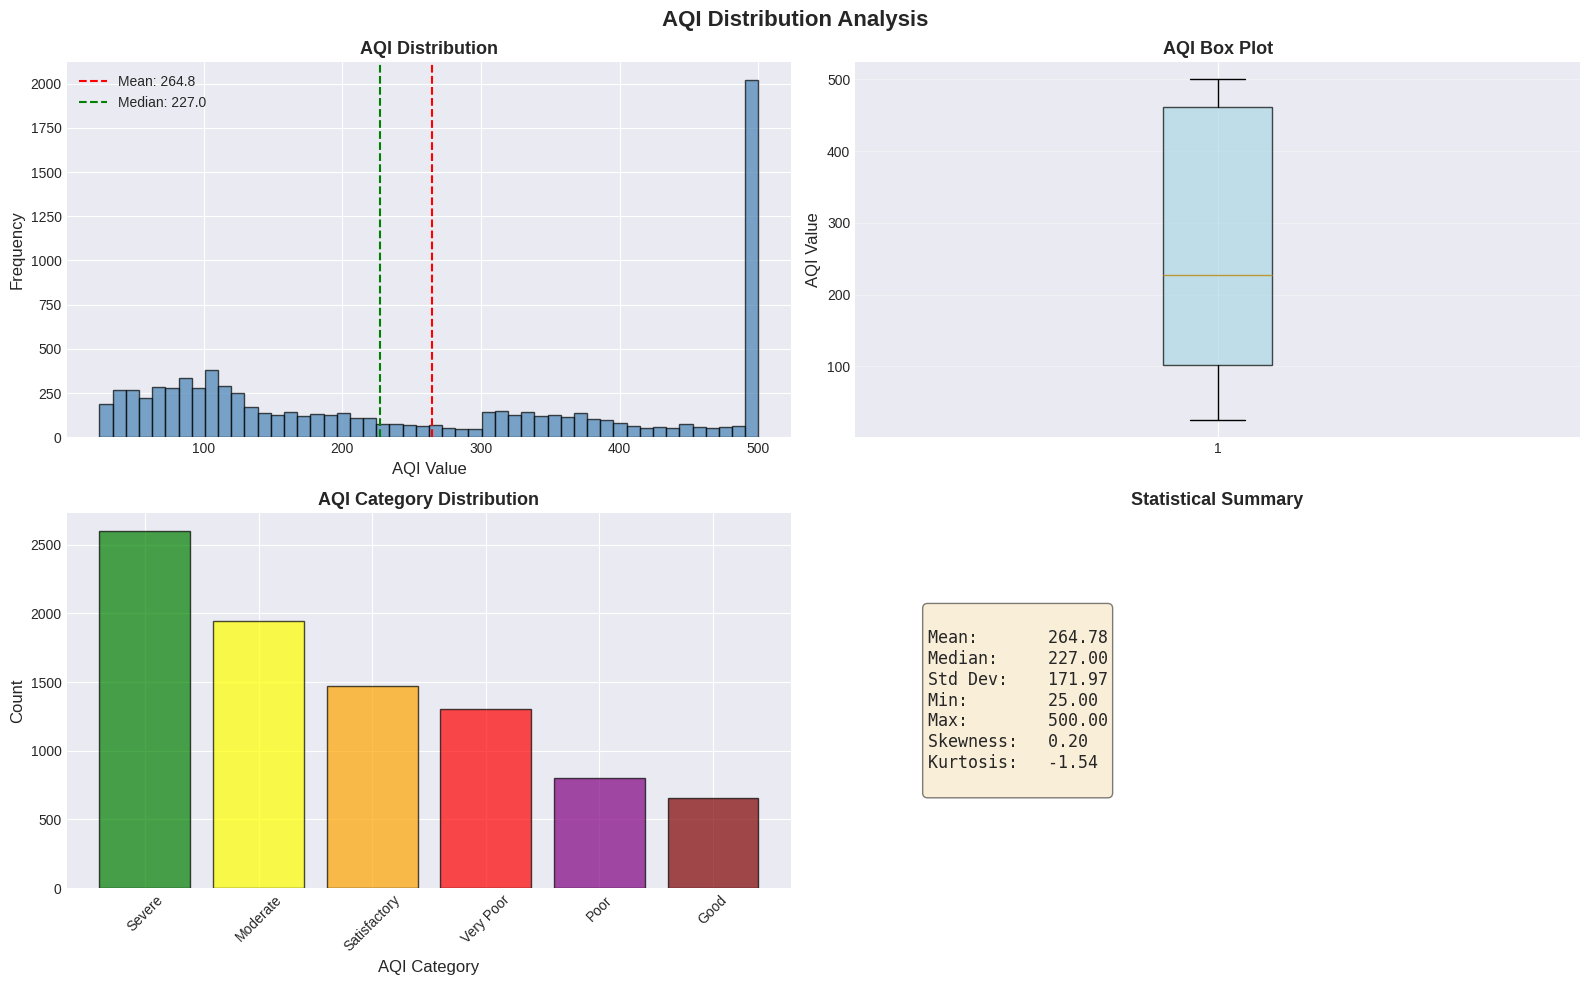

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('AQI Distribution Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0, 0].hist(df_clean['aqi'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('AQI Value', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('AQI Distribution', fontsize=13, fontweight='bold')
axes[0, 0].axvline(df_clean['aqi'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_clean["aqi"].mean():.1f}')
axes[0, 0].axvline(df_clean['aqi'].median(), color='green', linestyle='--',
                   label=f'Median: {df_clean["aqi"].median():.1f}')
axes[0, 0].legend()

# Box Plot
axes[0, 1].boxplot(df_clean['aqi'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 1].set_ylabel('AQI Value', fontsize=12)
axes[0, 1].set_title('AQI Box Plot', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# AQI Category Distribution
aqi_category_counts = df_clean['aqi_category'].value_counts()
colors_cat = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon']
axes[1, 0].bar(aqi_category_counts.index, aqi_category_counts.values,
               color=colors_cat[:len(aqi_category_counts)], alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('AQI Category', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('AQI Category Distribution', fontsize=13, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

# Statistical Summary Table
stats_text = f"""
Mean:       {df_clean['aqi'].mean():.2f}
Median:     {df_clean['aqi'].median():.2f}
Std Dev:    {df_clean['aqi'].std():.2f}
Min:        {df_clean['aqi'].min():.2f}
Max:        {df_clean['aqi'].max():.2f}
Skewness:   {skew(df_clean['aqi']):.2f}
Kurtosis:   {kurtosis(df_clean['aqi']):.2f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round',
                facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')
axes[1, 1].set_title('Statistical Summary', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

#### 3.2 Time Series Trend Analysis

In [20]:
# Resample to daily average for cleaner visualization
df_daily = df_clean.resample('D').agg({
    'aqi': 'mean',
    'pm25': 'mean' if 'pm25' in df_clean.columns else 'first',
    'pm10': 'mean' if 'pm10' in df_clean.columns else 'first',
    'temperature': 'mean' if 'temperature' in df_clean.columns else 'first'
})

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Daily Average AQI Over Time', 'PM2.5 vs PM10 Comparison'),
    vertical_spacing=0.12,
    row_heights=[0.5, 0.5]
)

# AQI Time Series
fig.add_trace(
    go.Scatter(x=df_daily.index, y=df_daily['aqi'],
               mode='lines', name='AQI',
               line=dict(color='#FF6B6B', width=1.5)),
    row=1, col=1
)

# Add 30-day moving average
df_daily['aqi_ma30'] = df_daily['aqi'].rolling(window=30).mean()
fig.add_trace(
    go.Scatter(x=df_daily.index, y=df_daily['aqi_ma30'],
               mode='lines', name='30-Day MA',
               line=dict(color='#4ECDC4', width=2, dash='dash')),
    row=1, col=1
)

# PM2.5 and PM10 comparison (if available)
if 'pm25' in df_daily.columns:
    fig.add_trace(
        go.Scatter(x=df_daily.index, y=df_daily['pm25'],
                   mode='lines', name='PM2.5',
                   line=dict(color='#95E1D3', width=1.5)),
        row=2, col=1
    )

if 'pm10' in df_daily.columns:
    fig.add_trace(
        go.Scatter(x=df_daily.index, y=df_daily['pm10'],
                   mode='lines', name='PM10',
                   line=dict(color='#F38181', width=1.5)),
        row=2, col=1
    )

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="AQI", row=1, col=1)
fig.update_yaxes(title_text="Concentration (μg/m³)", row=2, col=1)

fig.update_layout(height=800, title_text="Delhi AQI Time Series Analysis",
                  showlegend=True, hovermode='x unified')
fig.show()

#### 3.3 Seasonal Pattern Analysis

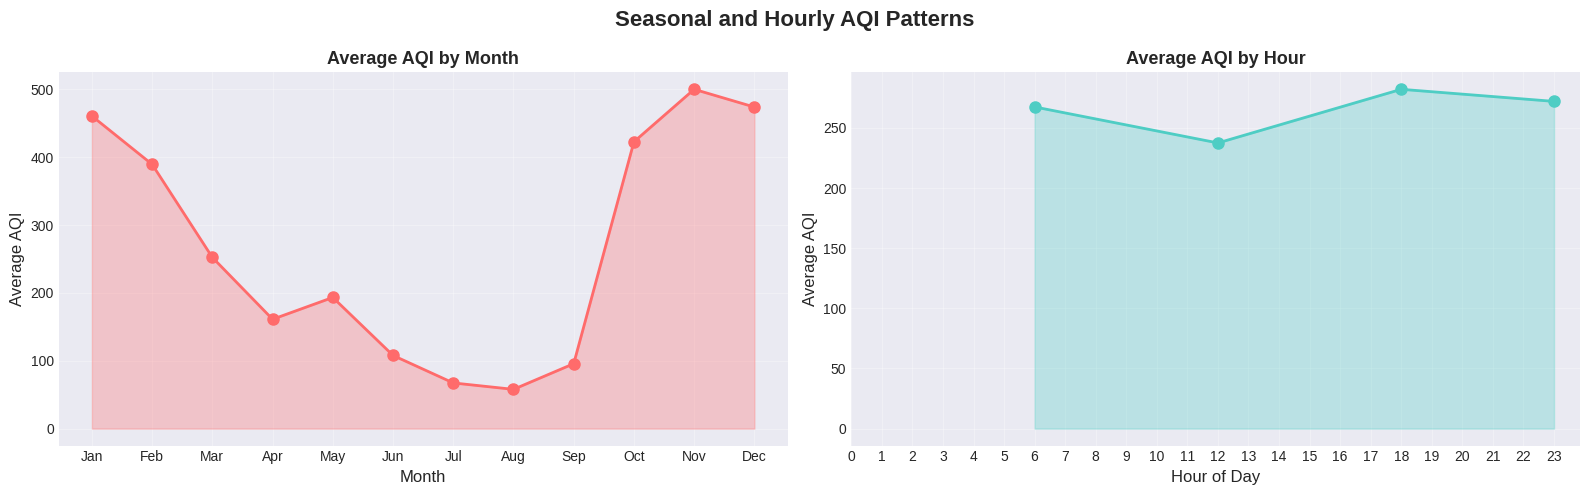


SEASONAL INSIGHTS
Highest pollution month: Nov (AQI: 500.0)
Lowest pollution month: Aug (AQI: 57.9)
Highest pollution hour: 18:00 (AQI: 282.1)
Lowest pollution hour: 12:00 (AQI: 237.5)


In [21]:
# Aggregate by month and hour to see patterns
df_clean_reset = df_clean.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Seasonal and Hourly AQI Patterns', fontsize=16, fontweight='bold')

# Monthly Average AQI
monthly_aqi = df_clean_reset.groupby('month')['aqi'].mean().sort_index()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0].plot(monthly_aqi.index, monthly_aqi.values, marker='o',
             linewidth=2, markersize=8, color='#FF6B6B')
axes[0].fill_between(monthly_aqi.index, monthly_aqi.values, alpha=0.3, color='#FF6B6B')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Average AQI', fontsize=12)
axes[0].set_title('Average AQI by Month', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(months)
axes[0].grid(alpha=0.3)

# Hourly Average AQI
hourly_aqi = df_clean_reset.groupby('hour')['aqi'].mean().sort_index()
axes[1].plot(hourly_aqi.index, hourly_aqi.values, marker='o',
             linewidth=2, markersize=8, color='#4ECDC4')
axes[1].fill_between(hourly_aqi.index, hourly_aqi.values, alpha=0.3, color='#4ECDC4')
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Average AQI', fontsize=12)
axes[1].set_title('Average AQI by Hour', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(0, 24))
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*80)
print("SEASONAL INSIGHTS")
print("="*80)
print(f"Highest pollution month: {months[monthly_aqi.idxmax()-1]} (AQI: {monthly_aqi.max():.1f})")
print(f"Lowest pollution month: {months[monthly_aqi.idxmin()-1]} (AQI: {monthly_aqi.min():.1f})")
print(f"Highest pollution hour: {hourly_aqi.idxmax()}:00 (AQI: {hourly_aqi.max():.1f})")
print(f"Lowest pollution hour: {hourly_aqi.idxmin()}:00 (AQI: {hourly_aqi.min():.1f})")

#### 3.4 Correlation Analysis

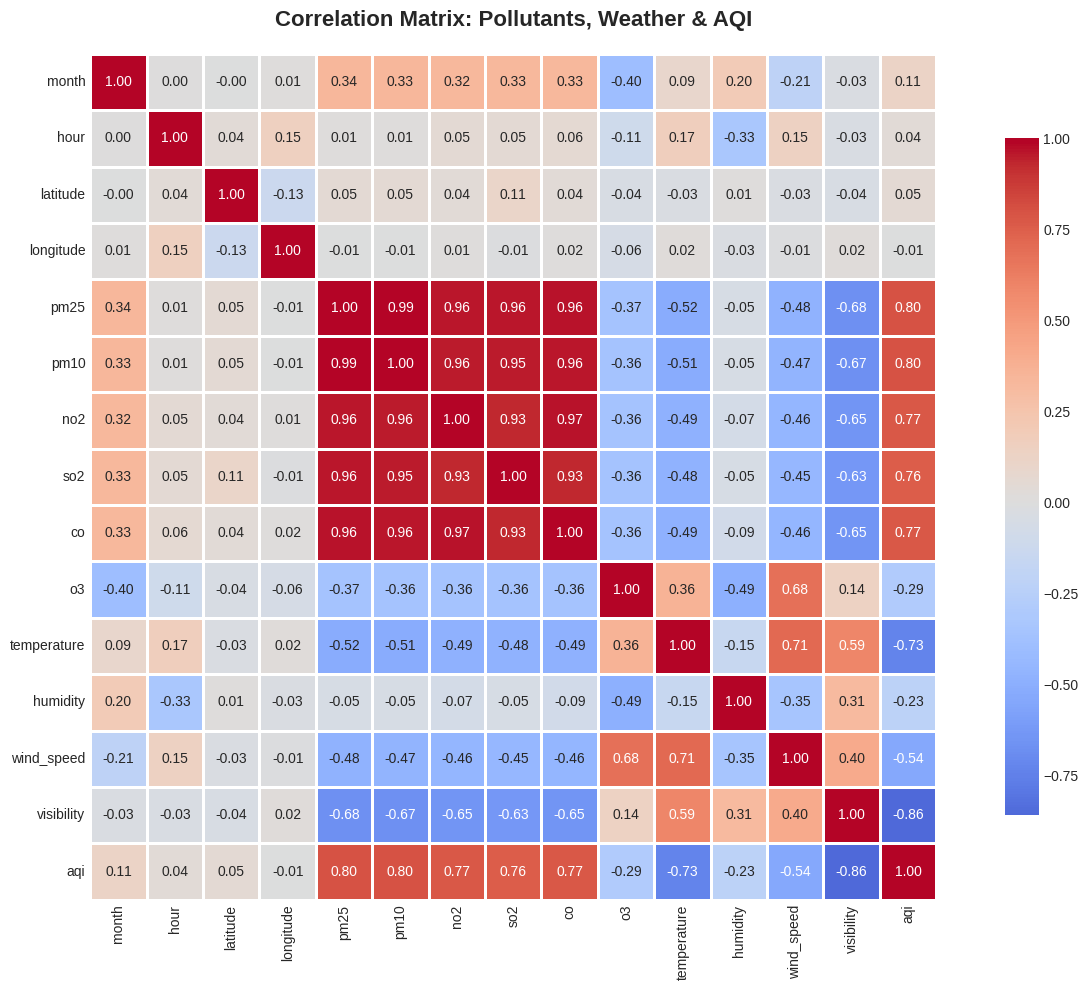


TOP CORRELATIONS WITH AQI


,aqi
pm25,0.801748
pm10,0.799730
no2,0.774530
co,0.774314
so2,0.756437
month,0.113974
latitude,0.049751
hour,0.038283
longitude,-0.007661
humidity,-0.226100


In [22]:
# Select numeric columns for correlation
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# Remove redundant columns
exclude_cols = ['year', 'day', 'is_weekend']
correlation_cols = [col for col in numeric_cols if col not in exclude_cols]

# Calculate correlation matrix
correlation_matrix = df_clean[correlation_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Pollutants, Weather & AQI',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print top correlations with AQI
print("\n" + "="*80)
print("TOP CORRELATIONS WITH AQI")
print("="*80)
aqi_corr = correlation_matrix['aqi'].sort_values(ascending=False)
display(aqi_corr.drop('aqi').head(10))

### Step 4: Feature Engineering

In [27]:
# Create a copy for feature engineering
df_features = df_clean.copy()
df_features_reset = df_features.reset_index()

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# 1. Lag Features (previous time steps)
print("\n1. Creating lag features...")
lag_periods = [1, 3, 6, 12, 24]  # 1, 3, 6, 12, and 24 hours ago

for lag in lag_periods:
    df_features[f'aqi_lag_{lag}'] = df_features['aqi'].shift(lag)
    if 'pm25' in df_features.columns:
        df_features[f'pm25_lag_{lag}'] = df_features['pm25'].shift(lag)

print(f"   ✓ Created lag features for periods: {lag_periods}")

# 2. Rolling Window Features (moving averages)
print("\n2. Creating rolling window features...")
windows = [3, 6, 12, 24]  # hours

for window in windows:
    df_features[f'aqi_rolling_mean_{window}'] = df_features['aqi'].rolling(window=window).mean()
    df_features[f'aqi_rolling_std_{window}'] = df_features['aqi'].rolling(window=window).std()
    df_features[f'aqi_rolling_min_{window}'] = df_features['aqi'].rolling(window=window).min()
    df_features[f'aqi_rolling_max_{window}'] = df_features['aqi'].rolling(window=window).max()

print(f"   ✓ Created rolling statistics for windows: {windows}")

# 3. Time-based Features (already present but let's verify)
print("\n3. Verifying time-based features...")
required_time_features = ['hour', 'day_of_week', 'month', 'season', 'is_weekend']
present_features = [f for f in required_time_features if f in df_features.columns]
print(f"   ✓ Present time features: {present_features}")

# 4. Interaction Features
print("\n4. Creating interaction features...")
if 'temperature' in df_features.columns and 'humidity' in df_features.columns:
    df_features['temp_humidity_interaction'] = df_features['temperature'] * df_features['humidity']
    print("   ✓ Created temperature × humidity interaction")

if 'wind_speed' in df_features.columns:
    df_features['temp_wind_interaction'] = df_features['temperature'] * df_features['wind_speed']
    print("   ✓ Created temperature × wind_speed interaction")

# 5. Cyclical Encoding for hour and month (important for ML models)
print("\n5. Creating cyclical features...")
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
print("   ✓ Created cyclical encodings for hour and month")

# Drop rows with NaN created by lag/rolling features
# Instead of df_features.dropna(), drop the initial rows that have NaNs due to lag/rolling features
max_lag_window = max(max(lag_periods), max(windows))
df_features_clean = df_features.iloc[max_lag_window:].copy()

print("\n" + "="*80)
print(f"FEATURE ENGINEERING COMPLETE")
print(f"Original features: {df_clean.shape[1]}")
print(f"New features: {df_features_clean.shape[1]}")
print(f"Rows after removing NaN: {df_features_clean.shape[0]} (from {df_clean.shape[0]})\n  (Dropped first {max_lag_window} rows due to lag/rolling features)")
print("="*80)

# Display sample of new features
print("\nSample of engineered features:")
display(df_features_clean[['aqi', 'aqi_lag_1', 'aqi_lag_24',
                            'aqi_rolling_mean_24', 'hour_sin', 'month_sin']].head(10))

FEATURE ENGINEERING

1. Creating lag features...
   ✓ Created lag features for periods: [1, 3, 6, 12, 24]

2. Creating rolling window features...
   ✓ Created rolling statistics for windows: [3, 6, 12, 24]

3. Verifying time-based features...
   ✓ Present time features: ['hour', 'day_of_week', 'month', 'season', 'is_weekend']

4. Creating interaction features...
   ✓ Created temperature × humidity interaction
   ✓ Created temperature × wind_speed interaction

5. Creating cyclical features...
   ✓ Created cyclical encodings for hour and month

FEATURE ENGINEERING COMPLETE
Original features: 24
New features: 56
Rows after removing NaN: 8744 (from 8768)
  (Dropped first 24 rows due to lag/rolling features)

Sample of engineered features:


,aqi,aqi_lag_1,aqi_lag_24,aqi_rolling_mean_24,hour_sin,month_sin
datetime,,,,,,
2020-01-07 06:00:00,500,500.0,500.0,464.541667,1.000000e+00,0.5
2020-01-07 12:00:00,350,500.0,414.0,461.875000,1.224647e-16,0.5
2020-01-07 18:00:00,500,350.0,500.0,461.875000,-1.000000e+00,0.5
2020-01-07 23:00:00,500,500.0,500.0,461.875000,-2.588190e-01,0.5
2020-01-08 06:00:00,500,500.0,500.0,461.875000,1.000000e+00,0.5
2020-01-08 12:00:00,441,500.0,387.0,464.125000,1.224647e-16,0.5
2020-01-08 18:00:00,500,441.0,381.0,469.083333,-1.000000e+00,0.5
2020-01-08 23:00:00,500,500.0,433.0,471.875000,-2.588190e-01,0.5
2020-01-09 06:00:00,500,500.0,500.0,471.875000,1.000000e+00,0.5


### Step 5: Predictive Modeling

#### 5.1 Data Preparation for Modeling

In [28]:
# Prepare features and target
print("="*80)
print("PREPARING DATA FOR MODELING")
print("="*80)

# Target variable
target = 'aqi'

# Features to exclude from training
exclude_features = ['aqi', 'aqi_category', 'date', 'city', 'datetime']
feature_columns = [col for col in df_features_clean.columns
                   if col not in exclude_features and df_features_clean[col].dtype in ['int64', 'float64']]

X = df_features_clean[feature_columns]
y = df_features_clean[target]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {len(feature_columns)}")

# Time series split (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test period: {df_features_clean.index[split_index]} to {df_features_clean.index[-1]}")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Feature scaling completed")

PREPARING DATA FOR MODELING

Features shape: (8744, 49)
Target shape: (8744,)

Number of features: 49

Training set: 6995 samples
Test set: 1749 samples
Test period: 2024-10-20 23:00:00 to 2025-12-31 23:00:00

✓ Feature scaling completed


#### 5.2 Model Training & Evaluation

In [29]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("\n" + "="*80)
print("MODEL TRAINING & EVALUATION")
print("="*80)

results = []

for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}...")
    print(f"{'='*40}")

    # Train model
    if 'Linear' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2
    })

    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")

# Display results
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
results_df = pd.DataFrame(results).sort_values('RMSE')
display(results_df)

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")


MODEL TRAINING & EVALUATION

Training Linear Regression...
MAE:  18.39
RMSE: 23.39
R²:   0.9831

Training Random Forest...
MAE:  0.13
RMSE: 0.37
R²:   1.0000

Training Gradient Boosting...
MAE:  0.92
RMSE: 1.66
R²:   0.9999

MODEL COMPARISON


,Model,MAE,RMSE,R² Score
1,Random Forest,0.126221,0.371833,0.999996
2,Gradient Boosting,0.920140,1.655824,0.999915
0,Linear Regression,18.393036,23.387360,0.983060



🏆 Best Model: Random Forest


#### 5.3 Feature Importance (for tree-based models)


TOP 15 MOST IMPORTANT FEATURES (Random Forest)


,Feature,Importance
7,pm25,9.025606e-01
8,pm10,9.743369e-02
29,aqi_rolling_min_3,1.056212e-06
33,aqi_rolling_min_6,2.634251e-07
9,no2,1.943494e-07
16,visibility,1.922168e-07
6,longitude,1.807157e-07
43,temp_humidity_interaction,1.803668e-07
15,wind_speed,1.765979e-07
10,so2,1.586288e-07


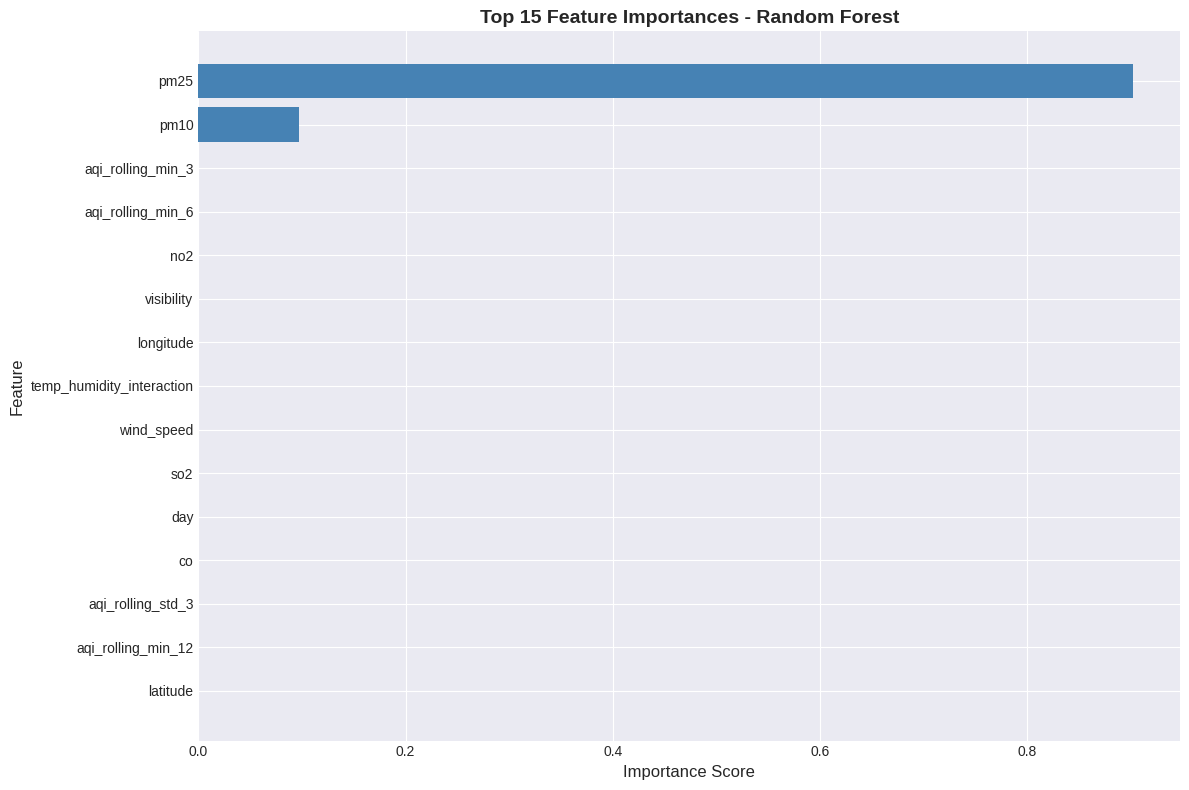

In [30]:
# Feature importance for Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']

    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*80)
    print("TOP 15 MOST IMPORTANT FEATURES (Random Forest)")
    print("="*80)
    display(feature_importance.head(15))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 15 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

#### 5.4 Prediction Visualization

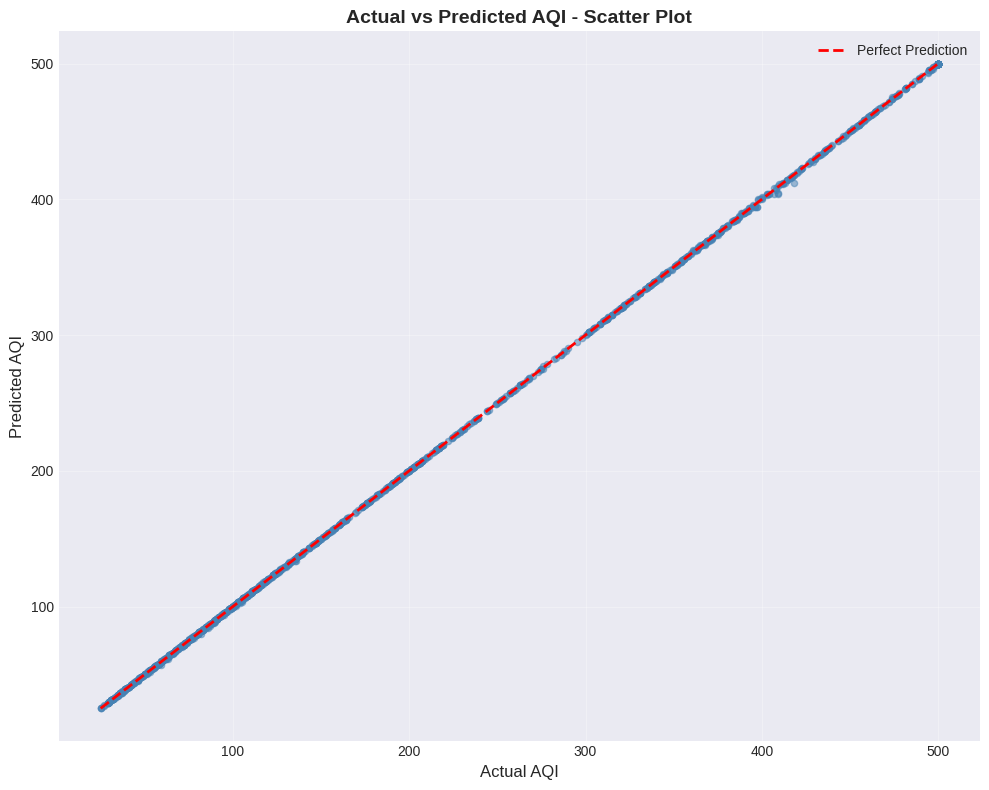


ERROR ANALYSIS
Mean Error: 0.02
Std Error: 0.37
Max Overestimation: -2.46
Max Underestimation: 5.76


In [31]:
# Make predictions with best model
if 'Linear' in best_model_name:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best
}, index=y_test.index)

# Plot actual vs predicted
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Actual vs Predicted AQI', 'Prediction Error Distribution'),
    vertical_spacing=0.15,
    row_heights=[0.6, 0.4]
)

# Time series comparison
fig.add_trace(
    go.Scatter(x=comparison_df.index, y=comparison_df['Actual'],
               mode='lines', name='Actual AQI',
               line=dict(color='#FF6B6B', width=2)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=comparison_df.index, y=comparison_df['Predicted'],
               mode='lines', name='Predicted AQI',
               line=dict(color='#4ECDC4', width=2, dash='dash')),
    row=1, col=1
)

# Error distribution
errors = comparison_df['Actual'] - comparison_df['Predicted']
fig.add_trace(
    go.Histogram(x=errors, nbinsx=50, name='Prediction Errors',
                 marker_color='#95E1D3'),
    row=2, col=1
)

fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Error (Actual - Predicted)", row=2, col=1)
fig.update_yaxes(title_text="AQI", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)

fig.update_layout(height=800, title_text=f"Model Performance: {best_model_name}",
                  showlegend=True, hovermode='x unified')
fig.show()

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'],
            alpha=0.5, s=20, color='steelblue')
plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Predicted AQI', fontsize=12)
plt.title('Actual vs Predicted AQI - Scatter Plot', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)
print(f"Mean Error: {errors.mean():.2f}")
print(f"Std Error: {errors.std():.2f}")
print(f"Max Overestimation: {errors.min():.2f}")
print(f"Max Underestimation: {errors.max():.2f}")

### Step 6: Key Insights & Recommendations

In [32]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM ANALYSIS")
print("="*80)

# 1. Most polluted periods
print("\n1. TEMPORAL PATTERNS:")
print(f"   • Peak pollution month: {months[monthly_aqi.idxmax()-1]}")
print(f"   • Peak pollution hour: {hourly_aqi.idxmax()}:00")
print(f"   • Lowest pollution month: {months[monthly_aqi.idxmin()-1]}")

# 2. AQI Category breakdown
print("\n2. AIR QUALITY DISTRIBUTION:")
category_pct = (df_clean['aqi_category'].value_counts() / len(df_clean) * 100).round(2)
for cat, pct in category_pct.items():
    print(f"   • {cat}: {pct}%")

# 3. Model performance
print(f"\n3. PREDICTIVE MODEL PERFORMANCE:")
print(f"   • Best Model: {best_model_name}")
print(f"   • RMSE: {results_df.iloc[0]['RMSE']:.2f} AQI units")
print(f"   • MAE: {results_df.iloc[0]['MAE']:.2f} AQI units")
print(f"   • R² Score: {results_df.iloc[0]['R² Score']:.4f}")

# 4. Top predictive features
if 'Random Forest' in models:
    print(f"\n4. TOP 5 PREDICTIVE FEATURES:")
    for idx, row in feature_importance.head(5).iterrows():
        print(f"   • {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("""
1. PUBLIC HEALTH ADVISORIES:
   • Issue alerts during peak pollution hours (evening rush hour)
   • Focus interventions during winter months (Oct-Jan)

2. POLICY INTERVENTIONS:
   • Implement traffic restrictions during high-risk periods
   • Monitor stubble burning activities in neighboring states

3. MODEL DEPLOYMENT:
   • Deploy the model for 24-hour ahead AQI forecasting
   • Integrate with mobile apps for real-time air quality updates

4. FURTHER ANALYSIS:
   • Include meteorological data (wind direction, precipitation)
   • Analyze spatial patterns across different Delhi zones
   • Study impact of major events (festivals, lockdowns)
""")

print("="*80)
print("ANALYSIS COMPLETE ✓")
print("="*80)


KEY INSIGHTS FROM ANALYSIS

1. TEMPORAL PATTERNS:
   • Peak pollution month: Nov
   • Peak pollution hour: 18:00
   • Lowest pollution month: Aug

2. AIR QUALITY DISTRIBUTION:
   • Severe: 29.64%
   • Moderate: 22.16%
   • Satisfactory: 16.79%
   • Very Poor: 14.86%
   • Poor: 9.1%
   • Good: 7.45%

3. PREDICTIVE MODEL PERFORMANCE:
   • Best Model: Random Forest
   • RMSE: 0.37 AQI units
   • MAE: 0.13 AQI units
   • R² Score: 1.0000

4. TOP 5 PREDICTIVE FEATURES:
   • pm25: 0.9026
   • pm10: 0.0974
   • aqi_rolling_min_3: 0.0000
   • aqi_rolling_min_6: 0.0000
   • no2: 0.0000

RECOMMENDATIONS

1. PUBLIC HEALTH ADVISORIES:
   • Issue alerts during peak pollution hours (evening rush hour)
   • Focus interventions during winter months (Oct-Jan)

2. POLICY INTERVENTIONS:
   • Implement traffic restrictions during high-risk periods
   • Monitor stubble burning activities in neighboring states

3. MODEL DEPLOYMENT:
   • Deploy the model for 24-hour ahead AQI forecasting
   • Integrate with